In [1]:
"""
Unit 5: Evolving Your IPD Agent with Genetic Algorithms
========================================================

In Unit 4, you hand-coded agent strategies like Tit-for-Tat.
In Unit 5, you'll use evolution to DISCOVER strategies automatically.

By the end, you'll have an evolved agent saved as a JSON file for the tournament!
"""

# ============================================================================
# SETUP: Import everything from previous units
# ============================================================================

import random
import numpy as np
import json
import matplotlib.pyplot as plt
from agents import Agent, INVEST, UNDERCUT
from game_engine import Game, Tournament

# Import all hand-coded agents from Unit 4
from agents import (
    AlwaysInvestAgent, AlwaysUndercutAgent, TitForTatAgent,
    GrimTriggerAgent, PavlovAgent, TitForTwoTatsAgent,
    GenerousTitForTatAgent, AdaptiveAgent, RandomAgent,
    SuspiciousTitForTatAgent, GradualAgent, HardMajorityAgent,
    SoftMajorityAgent, ProberAgent
)

print("✅ Imports complete!")

✅ Imports complete!


In [2]:

# ============================================================================
# PART 1: THE EVOLVABLE AGENT (PROVIDED - Read but don't modify)
# ============================================================================

class EvolvableAgent(Agent):
    """
    An agent whose strategy is controlled by 6 genes (numbers from 0 to 1).
    
    Think of genes as "strategy dials" you can tune:
    
    Gene[0] - Initial Cooperation (0=hostile start, 1=friendly start)
    Gene[1] - Cooperation Response (if opponent cooperates, how likely to cooperate back?)
    Gene[2] - Defection Response (if opponent defects, how likely to defect back?)
    Gene[3] - Forgiveness (after retaliation, chance to forgive)
    Gene[4] - Memory Length (0=last 1 round, 1=last 10 rounds)
    Gene[5] - Retaliation Threshold (what % of defections triggers retaliation)
    """
    
    def __init__(self, genes=None, name="Evolved Agent"):
        if genes is None:
            # Create random genes if none provided
            genes = [random.random() for _ in range(6)]
        
        self.genes = genes
        super().__init__(name, f"Genes: [{', '.join([f'{g:.2f}' for g in genes])}]")
    
    def choose_action(self) -> bool:
        """Decision logic based on genes - SIMPLIFIED FOR LEARNING"""
        
        # First 3 rounds: use initial cooperation gene
        if self.round_num < 3:
            return random.random() < self.genes[0]
        
        # Calculate memory window (gene[4])
        memory_length = max(1, int(self.genes[4] * 10) + 1)
        recent_history = self.history[-memory_length:]
        
        # Calculate opponent's recent COOPERATION rate (not defection!)
        cooperation_rate = sum(recent_history) / len(recent_history)
        
        # If opponent is mostly cooperating, reciprocate
        if cooperation_rate >= 0.5:
            return random.random() < self.genes[1]  # gene[1] = cooperate response
        
        # If opponent is mostly defecting, retaliate or forgive
        else:
            # Retaliate with probability gene[2]
            if random.random() < self.genes[2]:
                return UNDERCUT
            # Or forgive with probability gene[3]
            elif random.random() < self.genes[3]:
                return INVEST
            else:
                return UNDERCUT


In [3]:

# ============================================================================
# PART 2: DEFINE THE OPPONENT ECOSYSTEM
# ============================================================================

# ============================================================================
# EXPANDED OPPONENT POOL
# ============================================================================

# Full pool of all possible opponents
full_opponent_pool = [
    # Cooperative agents
    AlwaysInvestAgent(),
    TitForTatAgent(),
    GrimTriggerAgent(),
    PavlovAgent(),
    TitForTwoTatsAgent(),
    GenerousTitForTatAgent(),
    AdaptiveAgent(),
    
    # Aggressive agents
    AlwaysUndercutAgent(),
    SuspiciousTitForTatAgent(),
    
    # Sophisticated agents
    GradualAgent(),
    ProberAgent(),
    
    # Majority-based agents
    HardMajorityAgent(),
    SoftMajorityAgent(),
    
    # Random agents with different cooperation levels
    RandomAgent(0.9),
    RandomAgent(0.7),
    RandomAgent(0.5),
    RandomAgent(0.3),
    RandomAgent(0.1),
]

print(f"\n📚 Full opponent library: {len(full_opponent_pool)} agents available")

# For initial evolution, randomly sample opponents
opponent_pool = random.sample(full_opponent_pool, 10)

print(f"🎲 Randomly selected {len(opponent_pool)} opponents for this evolution:")
for i, opp in enumerate(opponent_pool, 1):
    print(f"  {i:2d}. {opp.name:25s} - {opp.description}")
print("="*70)




📚 Full opponent library: 18 agents available
🎲 Randomly selected 10 opponents for this evolution:
   1. Grim Trigger              - Invests until betrayed once, then undercuts forever
   2. Tit-for-Two-Tats          - Tolerates one betrayal, retaliates after two
   3. Always Undercut           - Always undercuts competitors
   4. Generous Tit-for-Tat      - Tit-for-Tat with 10% forgiveness
   5. Random (0.7)              - Randomly invests 70% of the time
   6. Random (0.1)              - Randomly invests 10% of the time
   7. Hard Majority             - Defects if opponent defects >50% of time
   8. Tit-for-Tat               - Starts friendly, then copies opponent
   9. Random (0.9)              - Randomly invests 90% of the time
  10. Random (0.3)              - Randomly invests 30% of the time


In [4]:

# ============================================================================
# PART 3: GENETIC ALGORITHM FUNCTIONS (YOUR TODO!)
# ============================================================================

def initialize_population(pop_size):
    """
    Create initial population of random agents.
    
    Args:
        pop_size: Number of agents in population
    
    Returns:
        List of EvolvableAgent objects with random genes
    """
    population = []
    for i in range(pop_size):
        agent = EvolvableAgent(name=f"Agent_{i}")
        population.append(agent)
    return population


def evaluate_fitness(agent, opponents, num_rounds=50):
    """
    Measure how good an agent is by playing against all opponents.
    
    Args:
        agent: The EvolvableAgent to evaluate
        opponents: List of opponent agents to play against
        num_rounds: Number of rounds per game
    
    Returns:
        Float: Average score per game (higher is better)
    """
    total_score = 0
    num_games = 0
    
    for opponent in opponents:
        game = Game(agent, opponent, num_rounds=num_rounds)
        score, _ = game.play()
        total_score += score
        num_games += 1
    
    avg_score = total_score / num_games
    return avg_score


def tournament_selection(population, fitnesses, tournament_size=5):
    """
    Select parents using tournament selection.
    
    Tournament selection:
    1. Pick tournament_size random individuals
    2. Choose the one with best fitness
    3. Repeat until we have pop_size selected parents
    
    Args:
        population: List of agents
        fitnesses: List of fitness scores (parallel to population)
        tournament_size: How many agents compete in each tournament
    
    Returns:
        List of selected agents (same length as population)
    """

    selected = []
    pop_size = len(population)

    for _ in range(pop_size):
        # 1. Randomly pick contestants
        contestants_idx = random.sample(range(pop_size), tournament_size)

        # 2. Choose the one with highest fitness
        best_idx = max(contestants_idx, key=lambda i: fitnesses[i])

        # 3. Copy the winner's genes
        winner_genes = population[best_idx].genes.copy()
        selected.append(EvolvableAgent(genes=winner_genes))

    return selected
    


def crossover_and_mutate(parent1, parent2, mutation_rate=0.15):
    """
    Create a child from two parents using crossover and mutation.
    
    Crossover (single-point):
    1. Pick a random split point (1 to 5)
    2. Take genes before split from parent1
    3. Take genes after split from parent2
    
    Mutation:
    1. For each gene, with probability=mutation_rate:
    2. Add Gaussian noise (mean=0, std=0.2)
    3. Clip gene to stay in range [0, 1]
    
    Args:
        parent1: First parent EvolvableAgent
        parent2: Second parent EvolvableAgent
        mutation_rate: Probability of mutating each gene
    
    Returns:
        New EvolvableAgent (the child)
    """


    # Randomize parent order to avoid bias
    if random.random() < 0.5:
        parent1, parent2 = parent2, parent1

    # crossover

    crossover_point = random.randint(1, len(parent1.genes) - 1)
    child_genes = parent1.genes[:crossover_point] + parent2.genes[crossover_point:]

    # mutation
    mutated = False
    for i in range(len(child_genes)):
        if random.random() < mutation_rate:
            child_genes[i] += random.gauss(0, 0.2)
            child_genes[i] = max(0.0, min(1.0, child_genes[i]))
            mutated = True
            
    # Ensure at least one mutation
    if not mutated:
        i = random.randint(0, len(child_genes)-1)
        child_genes[i] += random.gauss(0, 0.2)
        child_genes[i] = max(0.0, min(1.0, child_genes[i]))

    return EvolvableAgent(genes=child_genes)
  

def evolve(generations=25, pop_size=20, opponents=None, mutation_rate=0.15, elitism=2):
    """
    Run the genetic algorithm to evolve an agent.
    
    Process:
    1. Create initial random population
    2. For each generation:
       a. Evaluate fitness of all agents
       b. Select parents via tournament selection
       c. Create children via crossover & mutation
       d. Keep best agents (elitism)
    3. Return the best agent found
    
    Args:
        generations: Number of generations to evolve
        pop_size: Size of population
        opponents: List of opponents to evaluate against
        mutation_rate: Probability of gene mutation
        elitism: Number of best agents to keep unchanged
    
    Returns:
        Best EvolvableAgent found
    """
    if opponents is None:
        opponents = opponent_pool
    
    print(f"\n🧬 EVOLUTION STARTING")
    print(f"{'='*70}")
    print(f"Population: {pop_size} | Generations: {generations} | Mutation: {mutation_rate}")
    print(f"Opponents: {len(opponents)} | Elitism: {elitism}")
    print(f"{'='*70}\n")
    
    best_fitness_history = []
    avg_fitness_history = []
    
    population = initialize_population(pop_size)
    
    best_overall_agent = None
    best_overall_fitness = -float('inf')
    
    for gen in range(generations):
       
        
       # Evaluate fitness
        fitnesses = [evaluate_fitness(agent, opponents, num_rounds=50) for agent in population]

        
        # Track statistics
        best_fitness = max(fitnesses)
        avg_fitness = sum(fitnesses) / len(fitnesses)
        best_fitness_history.append(best_fitness)
        avg_fitness_history.append(avg_fitness)
        
        
        best_idx = fitnesses.index(best_fitness)
        if best_fitness > best_overall_fitness:
            best_overall_fitness = best_fitness
            best_overall_agent = EvolvableAgent(genes=population[best_idx].genes.copy())
        
        # Print progress
        print(f"Gen {gen+1:3d}/{generations}: "
              f"Best={best_fitness:6.2f} | Avg={avg_fitness:6.2f} | "
              f"Genes={[f'{g:.2f}' for g in population[best_idx].genes]}")
        
        # Create next generation
        if gen < generations - 1:
            # Elitism: copy top performers
            sorted_indices = sorted(range(len(fitnesses)), key=lambda i: fitnesses[i], reverse=True)
            next_population = [EvolvableAgent(genes=population[i].genes.copy()) for i in sorted_indices[:elitism]]

            # Tournament selection
            selected = tournament_selection(population, fitnesses)

            # Fill the rest of the population with offspring
            while len(next_population) < pop_size:
                parent1, parent2 = random.sample(selected, 2)
                child = crossover_and_mutate(parent1, parent2, mutation_rate)
                next_population.append(child)

            population = next_population
    
    print(f"\n{'='*70}")
    print(f"✅ EVOLUTION COMPLETE!")
    print(f"🏆 Best fitness achieved: {best_overall_fitness:.2f}")
    print(f"{'='*70}\n")
    
    # Plot evolution progress
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, generations+1), best_fitness_history, 
             label='Best Fitness', linewidth=2, color='green', marker='o')
    plt.plot(range(1, generations+1), avg_fitness_history, 
             label='Average Fitness', linewidth=2, color='blue', marker='s', alpha=0.7)
    plt.xlabel('Generation', fontsize=12)
    plt.ylabel('Fitness (Avg Score per Game)', fontsize=12)
    plt.title('Evolution Progress', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return best_overall_agent
    



🚀 TIME TO EVOLVE YOUR AGENT!

🧬 EVOLUTION STARTING
Population: 30 | Generations: 100 | Mutation: 0.1
Opponents: 10 | Elitism: 2

Gen   1/100: Best=114.70 | Avg= 99.14 | Genes=['0.93', '0.98', '0.57', '0.05', '0.41', '0.27']
Gen   2/100: Best=116.00 | Avg=103.10 | Genes=['0.99', '0.95', '0.78', '0.50', '0.59', '0.22']
Gen   3/100: Best=124.40 | Avg=110.31 | Genes=['0.99', '0.95', '0.78', '0.00', '0.41', '0.27']
Gen   4/100: Best=125.00 | Avg=117.04 | Genes=['1.00', '1.00', '0.57', '0.00', '0.68', '0.27']
Gen   5/100: Best=123.50 | Avg=118.55 | Genes=['1.00', '1.00', '0.36', '0.05', '0.60', '0.22']
Gen   6/100: Best=125.20 | Avg=118.59 | Genes=['0.99', '1.00', '0.85', '0.00', '0.48', '0.06']
Gen   7/100: Best=123.90 | Avg=118.65 | Genes=['1.00', '1.00', '0.85', '0.00', '0.48', '0.06']
Gen   8/100: Best=123.70 | Avg=120.04 | Genes=['1.00', '1.00', '0.85', '0.00', '0.48', '0.06']
Gen   9/100: Best=124.00 | Avg=119.49 | Genes=['1.00', '1.00', '0.85', '0.00', '0.48', '0.00']
Gen  10/100: Be

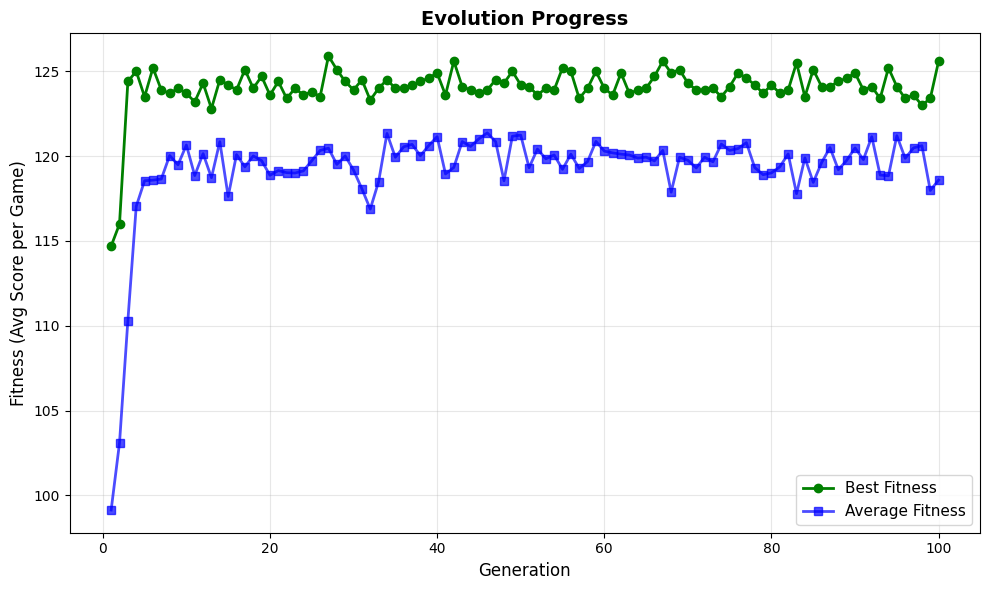


🎉 Your evolved agent's final genes:
   [1.0, 1.0, 1.0, 0.0, 0.0, 0.0]


In [5]:

# ============================================================================
# PART 4: RUN EVOLUTION! 
# ============================================================================

print("\n" + "="*70)
print("🚀 TIME TO EVOLVE YOUR AGENT!")
print("="*70)

# TODO: Experiment with these parameters to find the best agent!
my_evolved_agent = evolve(
    generations=100,       # Try: 50, 100, 250
    pop_size=30,         # Try: 15, 20, 30
    opponents=opponent_pool,
    mutation_rate=0.1,  # Try: 0.1, 0.15, 0.2
    elitism=2            # Keep top 2 agents each generation
)

print(f"\n🎉 Your evolved agent's final genes:")
print(f"   {my_evolved_agent.genes}")



In [7]:

# ============================================================================
# PART 5: TEST YOUR AGENT
# ============================================================================

print("\n" + "="*70)
print("⚔️  TESTING YOUR AGENT AGAINST HAND-CODED OPPONENTS")
print("="*70 + "\n")

wins = 0
losses = 0
ties = 0

for opponent in opponent_pool:
    game = Game(my_evolved_agent, opponent, num_rounds=100)
    my_score, opp_score = game.play()
    
    if my_score > opp_score:
        result = "✅ WON"
        wins += 1
    elif my_score < opp_score:
        result = "❌ LOST"
        losses += 1
    else:
        result = "🤝 TIED"
        ties += 1
    
    print(f"vs {opponent.name:25s}: {my_score:3d} - {opp_score:3d}  {result}")

print(f"\n📊 Record: {wins} wins, {losses} losses, {ties} ties")
win_rate = wins / len(opponent_pool) * 100
print(f"🎯 Win Rate: {win_rate:.1f}%")




⚔️  TESTING YOUR AGENT AGAINST HAND-CODED OPPONENTS

vs Grim Trigger             : 300 - 300  🤝 TIED
vs Tit-for-Two-Tats         : 300 - 300  🤝 TIED
vs Always Undercut          :  97 - 112  ❌ LOST
vs Generous Tit-for-Tat     : 300 - 300  🤝 TIED
vs Random (0.7)             : 261 - 266  ❌ LOST
vs Random (0.1)             : 108 - 123  ❌ LOST
vs Hard Majority            : 300 - 300  🤝 TIED
vs Tit-for-Tat              : 300 - 300  🤝 TIED
vs Random (0.9)             : 285 - 290  ❌ LOST
vs Random (0.3)             : 172 - 177  ❌ LOST

📊 Record: 0 wins, 5 losses, 5 ties
🎯 Win Rate: 0.0%


# Unit 5 Part 2: Benchmark Analysis

**After running your initial evolution and benchmark tests, answer these questions.**

---

## Performance Summary

Fill in your benchmark results:


| Opponent             | Result (W/L/T)  | Your Score | Opp Score |
| -------------------- | --------------- | ---------- | --------- |
| Always Invest        | T               | 300        | 300       |
| Always Undercut      | L               | 97         | 112       |
| Tit-for-Tat          | T               | 300        | 300       |
| Grim Trigger         | T               | 300        | 300       |
| Pavlov               | —               | —          | —         |
| Tit-for-Two-Tats     | T               | 300        | 300       |
| Generous Tit-for-Tat | T               | 300        | 300       |
| Adaptive             | —               | —          | —         |
| Random (0.7)         | L               | 261        | 266       |
| Random (0.3)         | L               | 172        | 177       |
| **Total**            | 0 W / 5 L / 5 T | —          | —         |

## Analysis Questions

### 1. What was your agent's worst loss (greatest point differential) and why?
My worst loss was against Always Undercut, where I scored 97 and they scored 112. I think this happened because my agent tends to cooperate early, while Always Undercut immediately takes advantage and punishes cooperation. My agent wasn’t aggressive enough to retaliate, so it lost points consistently in the early rounds, which built up the point differential.

### 2. What pattern do you see in wins vs. losses?
Looking at the results, my agent ties against mostly cooperative or reactive agents (like Tit-for-Tat, Grim Trigger, Generous Tit-for-Tat), but loses to random or aggressive agents (like Random 0.7, Random 0.3, Always Undercut). The pattern seems to be that my agent can handle predictable strategies but struggles against unpredictable or exploitative strategies.

---

### 3. What would make an agent more competitive?
I could add a better detection of aggressive/random opponents so it can switch strategies faster.
---

**Next:** Proceed to Part 3 to implement your improvements!

In [7]:

# ============================================================================
# PART 6: IMPROVE YOUR AGENT'S ACTION TAKING STRATEGY
# ============================================================================

class ImprovedEvolvableAgent(Agent):
    """
    IMPROVED agent with better gene encoding
    
    Students can modify:
    - Number of genes (currently 6, could add more)
    - What genes control
    - Decision logic (how genes map to actions)
    """
    
    def __init__(self, genes=None, name="Improved Agent"):
        if genes is None:
            # TODO: Students can change number of genes here
            genes = [random.random() for _ in range(6)]
        
        self.genes = genes
        super().__init__(name, f"Genes: [{', '.join([f'{g:.2f}' for g in genes])}]")
    
    def choose_action(self) -> bool:
        """
        IMPROVED decision logic - AGGRESSIVE VERSION
        More likely to retaliate, less exploitable
        """
        
        # First 3 rounds: use initial cooperation gene
        if self.round_num < 3:
            return random.random() < self.genes[0]
        
        # Calculate memory window
        memory_length = max(1, int(self.genes[4] * 10) + 1)
        recent_history = self.history[-memory_length:]
        cooperation_rate = sum(recent_history) / len(recent_history)
        
        # AGGRESSIVE STRATEGY: Higher threshold for cooperation
        
        # Only cooperate if opponent is VERY cooperative (>80%)
        if cooperation_rate > 0.8:
            return random.random() < self.genes[1]  # gene[1] should evolve HIGH
        
        # If somewhat cooperative (50-80%), be cautious
        elif cooperation_rate > 0.5:
            # Mix of cooperation and defection
            coop_prob = self.genes[1] * (cooperation_rate - 0.5) * 2  # Scale 0-1
            return random.random() < coop_prob
        
        # If aggressive (<50%), retaliate hard
        else:
            # Mostly defect, with small chance to forgive
            if random.random() < self.genes[3] * 0.3:  # Reduced forgiveness
                return INVEST
            else:
                return UNDERCUT
    
    def save_to_file(self, filename):
        """Save agent to JSON"""
        data = {
            'name': self.name,
            'genes': self.genes,
            'description': self.description
        }
        with open(filename, 'w') as f:
            json.dump(data, f, indent=2)
        print(f"✅ Agent saved to {filename}")


🔧 EVOLVING YOUR IMPROVED AGENT!

🧬 EVOLUTION STARTING (Improved Agent)
Population: 30 | Generations: 100 | Mutation: 0.1
Opponents: 10 | Elitism: 2

Gen   1/100: Best=125.90 | Avg=102.11 | Genes=['0.95', '0.76', '0.17', '0.62', '0.02', '0.44']
Gen   2/100: Best=126.50 | Avg=100.60 | Genes=['0.95', '0.76', '0.17', '0.62', '0.02', '0.44']
Gen   3/100: Best=127.40 | Avg=107.51 | Genes=['0.89', '0.52', '0.28', '0.56', '0.41', '0.63']
Gen   4/100: Best=128.70 | Avg=108.73 | Genes=['0.85', '0.92', '0.89', '0.80', '0.07', '0.34']
Gen   5/100: Best=128.70 | Avg=101.43 | Genes=['0.62', '0.98', '1.00', '0.12', '0.02', '0.25']
Gen   6/100: Best=128.70 | Avg=105.31 | Genes=['0.86', '0.76', '0.94', '0.44', '0.17', '0.33']
Gen   7/100: Best=128.70 | Avg=105.13 | Genes=['0.82', '0.74', '0.21', '0.23', '0.04', '0.60']
Gen   8/100: Best=128.70 | Avg=102.89 | Genes=['0.82', '0.74', '0.21', '0.23', '0.04', '0.60']
Gen   9/100: Best=128.70 | Avg=104.95 | Genes=['1.00', '0.95', '0.60', '0.37', '0.03', '0.

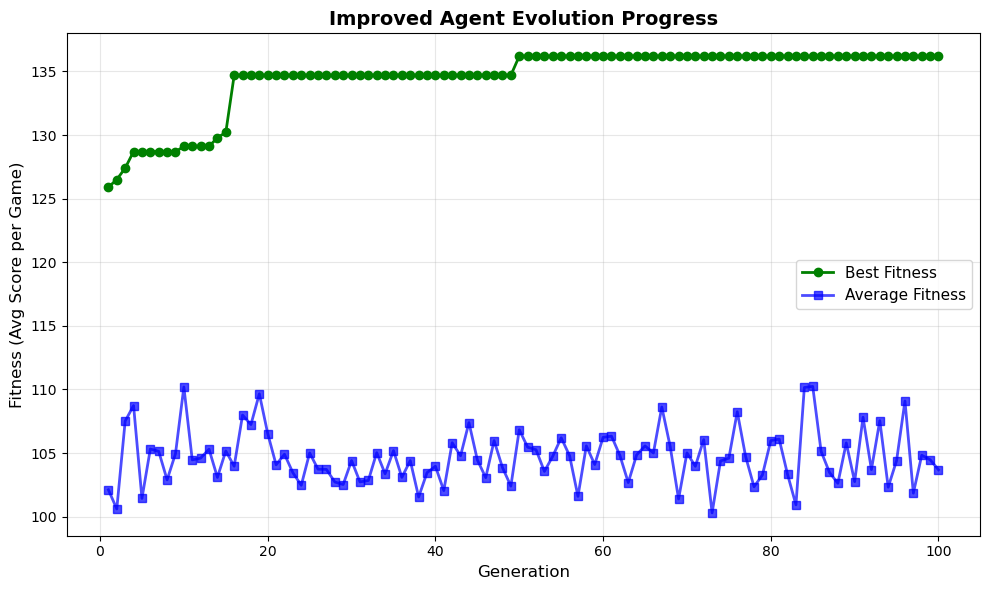


🎉 Your improved agent's final genes:
   [0.9970462326330012, 0.9747697307676272, 0.5775165988663097, 0.2694337203265058, 0.5915625504553477, 0.7908011628894027]


In [8]:
# ============================================================================
# PART 7: EVOLVE YOUR IMPROVED AGENT
# ============================================================================


print("\n" + "="*70)
print("🔧 EVOLVING YOUR IMPROVED AGENT!")
print("="*70)


def evolve_improved(generations=25, pop_size=20, opponents=None, mutation_rate=0.15, elitism=2):
    """
    Evolve using the ImprovedEvolvableAgent class
    (Same as evolve() but uses ImprovedEvolvableAgent instead of EvolvableAgent)
    """
    if opponents is None:
        opponents = opponent_pool
    
    print(f"\n🧬 EVOLUTION STARTING (Improved Agent)")
    print(f"{'='*70}")
    print(f"Population: {pop_size} | Generations: {generations} | Mutation: {mutation_rate}")
    print(f"Opponents: {len(opponents)} | Elitism: {elitism}")
    print(f"{'='*70}\n")
    
    best_fitness_history = []
    avg_fitness_history = []
    
    # Initialize population with ImprovedEvolvableAgent
    population = [ImprovedEvolvableAgent(name=f"Agent_{i}") for i in range(pop_size)]
    
    best_overall_agent = None
    best_overall_fitness = -float('inf')
    
    for gen in range(generations):
        # Evaluate fitness
        fitnesses = []
        for agent in population:
            fitness = evaluate_fitness(agent, opponents, num_rounds=50)
            fitnesses.append(fitness)
        
        # Track best
        best_fitness = max(fitnesses)
        avg_fitness = sum(fitnesses) / len(fitnesses)
        
        # Update best overall
        best_idx = fitnesses.index(best_fitness)
        if best_fitness > best_overall_fitness:
            best_overall_fitness = best_fitness
            best_overall_agent = ImprovedEvolvableAgent(genes=population[best_idx].genes.copy())
        
        best_fitness_history.append(best_overall_fitness)
        avg_fitness_history.append(avg_fitness)
        
        print(f"Gen {gen+1:3d}/{generations}: "
              f"Best={best_overall_fitness:6.2f} | Avg={avg_fitness:6.2f} | "
              f"Genes={[f'{g:.2f}' for g in population[best_idx].genes]}")
        
        # Create next generation
        if gen < generations - 1:
            sorted_indices = sorted(range(len(fitnesses)), 
                                  key=lambda i: fitnesses[i], 
                                  reverse=True)
            
            # Elitism
            next_population = []
            for i in range(elitism):
                elite_genes = population[sorted_indices[i]].genes.copy()
                next_population.append(ImprovedEvolvableAgent(genes=elite_genes))
            
            # Selection
            selected = tournament_selection(population, fitnesses)
            
            # Crossover and mutation
            while len(next_population) < pop_size:
                parent1, parent2 = random.sample(selected, 2)
                child = crossover_and_mutate(parent1, parent2, mutation_rate)
                # Convert to ImprovedEvolvableAgent
                next_population.append(ImprovedEvolvableAgent(genes=child.genes))
            
            population = next_population
    
    print(f"\n{'='*70}")
    print(f"✅ EVOLUTION COMPLETE!")
    print(f"🏆 Best fitness achieved: {best_overall_fitness:.2f}")
    print(f"{'='*70}\n")
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, generations+1), best_fitness_history, 
             label='Best Fitness', linewidth=2, color='green', marker='o')
    plt.plot(range(1, generations+1), avg_fitness_history, 
             label='Average Fitness', linewidth=2, color='blue', marker='s', alpha=0.7)
    plt.xlabel('Generation', fontsize=12)
    plt.ylabel('Fitness (Avg Score per Game)', fontsize=12)
    plt.title('Improved Agent Evolution Progress', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return best_overall_agent


# TODO: Experiment with these parameters to find the best improved agent!
my_improved_agent = evolve_improved(
    generations=100,      # Try: 20, 30, 50
    pop_size=30,         # Try: 15, 20, 30
    opponents=opponent_pool,
    mutation_rate=0.1,   # Try: 0.1, 0.15, 0.2
    elitism=2            # Keep top 2 agents each generation
)

print(f"\n🎉 Your improved agent's final genes:")
print(f"   {my_improved_agent.genes}")

In [9]:

# ============================================================================
# PART 8.1: Compare: Original vs Improved
# ============================================================================

print("\n" + "="*70)
print("📊 COMPARISON: Original vs Improved Agent")
print("="*70 + "\n")

print("ORIGINAL AGENT:")
wins_orig = 0
for opponent in opponent_pool:
    game = Game(my_evolved_agent, opponent, num_rounds=100)
    my_score, opp_score = game.play()
    if my_score > opp_score:
        wins_orig += 1
        result = "✅ WON"
    elif my_score < opp_score:
        result = "❌ LOST"
    else:
        result = "🤝 TIED"
    print(f"vs {opponent.name:25s}: {my_score:3d} - {opp_score:3d}  {result}")

print(f"\nOriginal Win Rate: {wins_orig / len(opponent_pool) * 100:.1f}%")

print("\n" + "-"*70 + "\n")

print("IMPROVED AGENT:")
wins_improved = 0
for opponent in opponent_pool:
    game = Game(my_improved_agent, opponent, num_rounds=100)
    my_score, opp_score = game.play()
    if my_score > opp_score:
        wins_improved += 1
        result = "✅ WON"
    elif my_score < opp_score:
        result = "❌ LOST"
    else:
        result = "🤝 TIED"
    print(f"vs {opponent.name:25s}: {my_score:3d} - {opp_score:3d}  {result}")

print(f"\nImproved Win Rate: {wins_improved / len(opponent_pool) * 100:.1f}%")

print("\n" + "="*70)
print(f"📈 IMPROVEMENT: +{wins_improved - wins_orig} wins")
print("="*70)


# ============================================================================
# GENERALIZATION TEST: Full Opponent Pool
# ============================================================================

print("\n" + "="*70)
print("🌍 GENERALIZATION TEST: Against ALL Possible Opponents")
print("="*70 + "\n")

print("Testing improved agent against the FULL opponent library:")
print("(including agents it was NOT trained on)\n")

wins_full = 0
losses_full = 0
ties_full = 0

for opponent in full_opponent_pool:
    game = Game(my_improved_agent, opponent, num_rounds=100)
    my_score, opp_score = game.play()
    
    if my_score > opp_score:
        result = "✅ WON"
        wins_full += 1
    elif my_score < opp_score:
        result = "❌ LOST"
        losses_full += 1
    else:
        result = "🤝 TIED"
        ties_full += 1
    
    # Mark if this was a training opponent
    trained_on = "📚" if any(opponent.name == o.name for o in opponent_pool) else "🆕"
    print(f"{trained_on} vs {opponent.name:25s}: {my_score:3d} - {opp_score:3d}  {result}")

print(f"\n📊 Results against ALL {len(full_opponent_pool)} opponents:")
print(f"   Wins: {wins_full} | Losses: {losses_full} | Ties: {ties_full}")
print(f"   Win Rate: {wins_full / len(full_opponent_pool) * 100:.1f}%")
print(f"\n💡 Legend: 📚 = Trained on this opponent | 🆕 = Never seen before")
print("="*70)


📊 COMPARISON: Original vs Improved Agent

ORIGINAL AGENT:
vs Random (0.9)             : 332 - 222  ✅ WON
vs Gradual                  : 193 - 188  ✅ WON
vs Soft Majority            : 347 - 227  ✅ WON
vs Suspicious Tit-for-Tat   : 243 - 248  ❌ LOST
vs Pavlov                   : 240 - 165  ✅ WON
vs Tit-for-Tat              : 209 - 209  🤝 TIED
vs Random (0.3)             : 186 - 181  ✅ WON
vs Tit-for-Two-Tats         : 330 - 220  ✅ WON
vs Random (0.1)             : 114 - 184  ❌ LOST
vs Hard Majority            : 360 - 210  ✅ WON

Original Win Rate: 70.0%

----------------------------------------------------------------------

IMPROVED AGENT:
vs Random (0.9)             : 303 - 268  ✅ WON
vs Gradual                  : 293 - 298  ❌ LOST
vs Soft Majority            : 304 - 294  ✅ WON
vs Suspicious Tit-for-Tat   : 142 - 142  🤝 TIED
vs Pavlov                   : 278 - 123  ✅ WON
vs Tit-for-Tat              : 143 - 138  ✅ WON
vs Random (0.3)             : 210 - 115  ✅ WON
vs Tit-for-Two-Tats   

In [10]:

# ============================================================================
# PART 8.2: Compete in your final tournament
# ============================================================================

print("\n" + "="*70)
print("🏆 FULL TOURNAMENT COMPARISON")
print("="*70 + "\n")

# Create tournament with original agent
print("Running tournament with ORIGINAL agent...")
original_tournament_agents = full_opponent_pool + [my_evolved_agent]
original_tournament = Tournament(original_tournament_agents, rounds_per_match=100, num_tournaments=1)
original_tournament.run_tournament()

# Create tournament with improved agent
print("\n" + "-"*70)
print("\nRunning tournament with IMPROVED agent...")
improved_tournament_agents = full_opponent_pool + [my_improved_agent]
improved_tournament = Tournament(improved_tournament_agents, rounds_per_match=100, num_tournaments=1)
improved_tournament.run_tournament()

# Compare rankings
print("\n" + "="*70)
print("📊 TOURNAMENT RESULTS COMPARISON")
print("="*70 + "\n")

original_rankings = original_tournament.get_rankings()
improved_rankings = improved_tournament.get_rankings()

# Find where each agent placed
original_rank = None
improved_rank = None
original_score = None
improved_score = None

for rank, (name, score) in enumerate(original_rankings, 1):
    if name == my_evolved_agent.name:
        original_rank = rank
        original_score = score

for rank, (name, score) in enumerate(improved_rankings, 1):
    if name == my_improved_agent.name:
        improved_rank = rank
        improved_score = score

print(f"ORIGINAL AGENT:")
print(f"  Rank: {original_rank} / {len(original_rankings)}")
print(f"  Total Score: {original_score:,}")
print()
print(f"IMPROVED AGENT:")
print(f"  Rank: {improved_rank} / {len(improved_rankings)}")
print(f"  Total Score: {improved_score:,}")
print()
print(f"IMPROVEMENT:")
print(f"  Rank Change: {original_rank - improved_rank} positions {'⬆️' if improved_rank < original_rank else '⬇️' if improved_rank > original_rank else '➡️'}")
print(f"  Score Change: +{improved_score - original_score:,} points ({(improved_score - original_score)/original_score*100:.1f}%)")
print("="*70)

# Show full leaderboard
print("\n🏆 IMPROVED AGENT TOURNAMENT LEADERBOARD:")
print("=" * 50)
for rank, (name, score) in enumerate(improved_rankings, 1):
    emoji = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else "  "
    marker = " ⭐ YOUR AGENT" if name == my_improved_agent.name else ""
    print(f"{emoji} {rank:2d}. {name:25s}: {score:,} points{marker}")


🏆 FULL TOURNAMENT COMPARISON

Running tournament with ORIGINAL agent...
Running 1 tournament(s) with 19 agents...
Match 1/342: Always Invest vs Tit-for-Tat
Match 2/342: Always Invest vs Grim Trigger
Match 3/342: Always Invest vs Pavlov
Match 4/342: Always Invest vs Tit-for-Two-Tats
Match 5/342: Always Invest vs Generous Tit-for-Tat
Match 6/342: Always Invest vs Adaptive
Match 7/342: Always Invest vs Always Undercut
Match 8/342: Always Invest vs Suspicious Tit-for-Tat
Match 9/342: Always Invest vs Gradual
Match 10/342: Always Invest vs Prober
Match 11/342: Always Invest vs Hard Majority
Match 12/342: Always Invest vs Soft Majority
Match 13/342: Always Invest vs Random (0.9)
Match 14/342: Always Invest vs Random (0.7)
Match 15/342: Always Invest vs Random (0.5)
Match 16/342: Always Invest vs Random (0.3)
Match 17/342: Always Invest vs Random (0.1)
Match 18/342: Always Invest vs Evolved Agent
Match 19/342: Tit-for-Tat vs Always Invest
Match 20/342: Tit-for-Tat vs Grim Trigger
Match 21/34

In [14]:
# ============================================================================
# PART 9: Export Complete Agent as Python Module
# ============================================================================

import inspect
from datetime import datetime

def export_complete_agent(agent, student_name, generations=100, final_fitness=None):
    """
    Export agent as a complete, standalone Python module.
    This preserves BOTH genes AND decision logic so your strategy maintains
    its competitive edge in the tournament!
    
    Args:
        agent: Your evolved ImprovedEvolvableAgent
        student_name: Your name (will be used in class name, e.g., "JohnSmith")
        generations: Number of generations you evolved for
        final_fitness: Your agent's final fitness score (optional)
    
    Returns:
        filename of the exported Python file
    """
    
    # Clean up student name for valid Python class name (remove spaces, special chars)
    clean_name = ''.join(c for c in student_name if c.isalnum())
    
    # Get the actual decision logic code
    decision_code = inspect.getsource(agent.choose_action)
    
    # The source code already has proper indentation from the class,
    # so we don't need to add extra indentation
    
    # Get training opponent names if available
    try:
        opponent_names = [opp.name for opp in opponent_pool]
        opponent_info = f"Trained against: {', '.join(opponent_names[:5])}{'...' if len(opponent_names) > 5 else ''}"
    except:
        opponent_info = "Training opponents: [info not available]"
    
    # Build the complete Python module
    code = f'''#!/usr/bin/env python
"""
Tournament Agent: {agent.name}
Student: {student_name}
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

Evolution Details:
- Generations: {generations}
- Final Fitness: {final_fitness if final_fitness else 'N/A'}
- {opponent_info}

Strategy: {agent.description}
"""

from agents import Agent, INVEST, UNDERCUT
import random


class {clean_name}Agent(Agent):
    """
    {agent.name}
    
    {agent.description}
    
    Evolved Genes: {agent.genes}
    """
    
    def __init__(self):
        # These genes were evolved through {generations} generations
        self.genes = {agent.genes}
        
        # Required for tournament compatibility
        self.student_name = "{student_name}"
        
        super().__init__(
            name="{agent.name}",
            description="{agent.description}"
        )
    
{decision_code}


# Convenience function for tournament loading
def get_agent():
    """Return an instance of this agent for tournament use"""
    return {clean_name}Agent()


if __name__ == "__main__":
    # Test that the agent can be instantiated
    agent = get_agent()
    print(f"✅ Agent loaded successfully: {{agent.name}}")
    print(f"   Genes: {{agent.genes}}")
    print(f"   Description: {{agent.description}}")
'''
    
    # Save to file
    filename = f"{clean_name.lower()}_tournament_agent.py"
    with open(filename, 'w') as f:
        f.write(code)
    
    print("="*70)
    print("✅ COMPLETE TOURNAMENT AGENT EXPORTED!")
    print("="*70)
    print(f"📄 File: {filename}")
    print(f"🏷️  Class: {clean_name}Agent")
    print(f"🧬 Genes: {agent.genes}")
    print()
    print("📦 What's included:")
    print("   ✓ Your evolved gene values")
    print("   ✓ Your complete decision logic (choose_action method)")
    print("   ✓ All metadata and documentation")
    print()
    print("🎯 Next Steps:")
    print(f"   1. Download '{filename}' from Jupyter")
    print("   2. Submit this .py file for the Unit 6 tournament")
    print("   3. Your strategy will compete exactly as it evolved!")
    print()
    print("🧪 Test your export:")
    print(f"   from {filename[:-3]} import get_agent")
    print("   my_agent = get_agent()")
    print("="*70)
    
    return filename


# ============================================================================
# RUN THIS: Export your improved agent
# ============================================================================

print("\n" + "="*70)
print("💾 EXPORTING YOUR TOURNAMENT AGENT")
print("="*70 + "\n")

# TODO: Customize these fields with your information
STUDENT_NAME = "Doug Dahl"  # <-- CHANGE THIS! (e.g., "JohnSmith" or "Alex_Chen")

# TODO: Give your agent a creative name and description
my_improved_agent.name = "King kong"  # <-- CHANGE THIS! (e.g., "Vengeful Cooperator", "Strategic Punisher")
my_improved_agent.description = "climb to the top of the empire state building"  # <-- CHANGE THIS! (e.g., "Cooperates with cooperative opponents but retaliates quickly against defectors")

print(f"Agent Name: {my_improved_agent.name}")
print(f"Description: {my_improved_agent.description}")
print(f"Genes: {[f'{g:.2f}' for g in my_improved_agent.genes]}\n")

# Export with all the context
exported_file = export_complete_agent(
    agent=my_improved_agent,
    student_name=STUDENT_NAME,
    generations=100,  # Update if you used different value
    final_fitness=None  # Optionally add your best fitness score (e.g., 85.2)
)

print(f"\n✨ Your agent is ready for tournament competition!")
print(f"   Unlike JSON exports, this preserves your evolved strategy.\n")



💾 EXPORTING YOUR TOURNAMENT AGENT

Agent Name: King kong
Description: climb to the top of the empire state building
Genes: ['1.00', '0.97', '0.58', '0.27', '0.59', '0.79']

✅ COMPLETE TOURNAMENT AGENT EXPORTED!
📄 File: dougdahl_tournament_agent.py
🏷️  Class: DougDahlAgent
🧬 Genes: [0.9970462326330012, 0.9747697307676272, 0.5775165988663097, 0.2694337203265058, 0.5915625504553477, 0.7908011628894027]

📦 What's included:
   ✓ Your evolved gene values
   ✓ Your complete decision logic (choose_action method)
   ✓ All metadata and documentation

🎯 Next Steps:
   1. Download 'dougdahl_tournament_agent.py' from Jupyter
   2. Submit this .py file for the Unit 6 tournament
   3. Your strategy will compete exactly as it evolved!

🧪 Test your export:
   from dougdahl_tournament_agent import get_agent
   my_agent = get_agent()

✨ Your agent is ready for tournament competition!
   Unlike JSON exports, this preserves your evolved strategy.



## Post-Evolution Reflection Questions

### 1. Generalization Analysis
- Compare your agent's performance on training opponents (📚) vs. unseen opponents (🆕)
- Did your agent generalize well or overfit to the training set?
- What does this suggest about evolving against a random sample vs. fixed opponents?

### 2. Tournament Performance
- What was your agent's final tournament rank? _____ out of _____
- What was your agent's total score? _____
- Look at agents that ranked above and below you - what strategies do they use?

### 3. Strategy Analysis
Look at your evolved genes: [____________________]

- In plain English, what strategy did your agent evolve?
- Does it cooperate with cooperators? Does it punish defectors?
- Why do you think evolution discovered this particular strategy?

### 4. Trade-offs
Every strategy has strengths and weaknesses.

- Which types of opponents does your agent beat?
- Which types beat your agent?
- If you could redesign your agent for Unit 6, what would you change?

### 5. The Environment Matters
- You evolved against a random sample of 10 opponents
- The tournament included all 19 opponents
- Unit 6 will include 30+ student agents with unpredictable strategies
- How might your agent perform in that different environment?